<a href="https://colab.research.google.com/github/shaojiezhanglalala/MachineLearning/blob/main/transfer_learning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
!unzip /content/hymenoptera_data.zip 

# **这两个主要的迁移学习方案如下所示：**
------------------------------
  **卷积网络的微调：**代替随机初始化，我们使用经过预训练的网络初始化网络，例如在 imagenet 1000 数据集上进行训练的网络。 其余的训练照常进行。<br/>
  **作为固定特征提取器的 ConvNet：**在这里，我们将冻结除最终全连接层之外的所有网络的权重。 最后一个全连接层将替换为具有随机权重的新层，并且仅训练该层。

In [ ]:
# 导包
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time 
import os
import copy

plt.ion() # 打开plt的交互模式，plt会直接画出图像，并不会阻塞程序的运行

In [ ]:
# 加载数据并处理数据
data_transforms = {
    'train':  transforms.Compose(
        [
         transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
    ),
    'val':  transforms.Compose(
        [
         transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
    )
}
data_dir = '/content/hymenoptera_data'
image_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x),
          data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_dataset[x],
          batch_size=4, shuffle=True, num_workers=0)
          for x in ['train', 'val']}
dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'val']}
class_names = image_dataset['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


因为在plt.imshow在现实的时候输入的是 
（imagesize,imagesize,channels）<br/>

imshow中，参数img的格式为（channels,imagesize,imagesize）<br/>

这两者的格式不一致，我们需要调用一次np.transpose函数，即np.transpose(npimg,(1,2,0))<br/>将npimg的数据格式由（channels,imagesize,imagesize）转化为（imagesize,imagesize,channels）,进行格式的转换后方可进行显示。


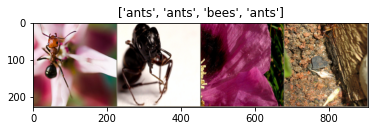

In [ ]:
def imshow(inp, title=None):
  # imshow for tensor
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = inp * std + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.5)

# 获取train数据集的一批次数据
inputs, classes = next(iter(dataloaders['train']))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


##**训练模型**

现在，让我们编写一个通用函数来训练模型。 在这里，我们将说明：
1.   安排学习率
2.   保存最佳模型



In [ ]:
from torch.nn.modules import module
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  # 训练开始时间(
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  # 开始迭代训练
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-'*10)

    # 每个epoch有两个阶段：训练阶段、验证阶段
    for phase in ['train', 'val']:
      # 设置模型状态
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      # 初始化epoch的训练损失和准确率
      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 将模型梯度归零
        optimizer.zero_grad()

        # 前向传播
        with torch.set_grad_enabled(phase == 'train'):
          outs = model(inputs)
          _, preds = torch.max(outs, dim = 1)
          loss = criterion(outs, labels)

          # 在训练阶段：方向传播 + 优化器 
          if phase == 'train':
            loss.backward()
            optimizer.step()
          # 统计阶段
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()
      
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects / dataset_sizes[phase]

      print('{} Loss:{:.4f} Acc:{:.4f}'.format(
          phase, epoch_loss, epoch_acc))

      # 深度拷贝模型参数 如果验证准确率达到当前最优
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print() 

  time_eplased = time.time() - since
  print('Training complete in {:.0f}min {:0f}sec'.format(
      time_eplased // 60, time_eplased % 60
  ))
  print('Best val Acc: {:4f}'.format(best_acc))

  # 加载最优模型参数
  model.load_state_dict(best_model_wts)
  return model
  

# 可视化模型预测
-----------------
通用函数，显示一些图像的预测

In [21]:
def visualize_model(model, num_images=6):
  was_training = model.training
  print("was_training:{}".format(was_training))
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      # 前向传播
      outputs = model(inputs)
      _, preds = torch.max(outputs, dim=1)

      for j in range(inputs.size()[0]):

        images_so_far += 1
        ax = plt.subplot(num_images // 2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)


# 微调ConvNet
加载预训练的模型并重置最终的全连接层

In [ ]:
# 加载ResNet18的预训练模型
model_ft = models.resnet18(pretrained=True)
# 获取fc层的输入通道数量
num_ftrs = model_ft.fc.in_features

# 这类fc层的输出结果只有两个，蜜蜂和蚂蚁
model_ft.fc = nn.Linear(num_ftrs, 2)

# 将模型转换到gpu上
model_ft = model_ft.to(device)

# 设置损失函数
criterion = nn.CrossEntropyLoss()

# 设置优化器
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 学习率每七轮衰减0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

# 训练和评估
-------------
在cpu上训练约15—25分钟，在gpu上3-4分钟

In [ ]:
# 训练模型，并返回最佳模型
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------
train Loss:0.3225 Acc:0.8566
val Loss:0.2435 Acc:0.9281

Epoch 1/24
----------
train Loss:0.2953 Acc:0.8934
val Loss:0.2804 Acc:0.9020

Epoch 2/24
----------
train Loss:0.3268 Acc:0.8525
val Loss:0.2445 Acc:0.9085

Epoch 3/24
----------
train Loss:0.2847 Acc:0.8730
val Loss:0.2378 Acc:0.9216

Epoch 4/24
----------
train Loss:0.3335 Acc:0.8525
val Loss:0.2258 Acc:0.9150

Epoch 5/24
----------
train Loss:0.3151 Acc:0.8566
val Loss:0.2132 Acc:0.9216

Epoch 6/24
----------
train Loss:0.2508 Acc:0.8852
val Loss:0.2288 Acc:0.9281

Epoch 7/24
----------
train Loss:0.2472 Acc:0.8975
val Loss:0.2189 Acc:0.9216

Epoch 8/24
----------
train Loss:0.2565 Acc:0.8893
val Loss:0.2825 Acc:0.9085

Epoch 9/24
----------
train Loss:0.3210 Acc:0.8402
val Loss:0.2371 Acc:0.9216

Epoch 10/24
----------
train Loss:0.2091 Acc:0.9180
val Loss:0.2276 Acc:0.9281

Epoch 11/24
----------
train Loss:0.3053 Acc:0.8689
val Loss:0.2451 Acc:0.9216

Epoch 12/24
----------
train Loss:0.2988 Acc:0.877

was_training:False


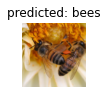

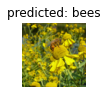

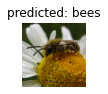

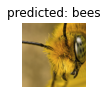

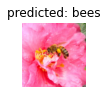

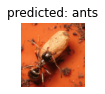

In [22]:
# 可视化一些预测结果
visualize_model(model_ft)

# 作为固定特征提取器的ConvNet
---------
冻结除最后一层之外的所有网络，即需要设置requires_grad == False冻结参数，以便不再backward()中计算梯度

In [ ]:
# 设置resnet18预训练模型
model_conv = torchvision.models.resnet18(pretrained=True)

# 冻结除最后一层的所有网络
for param in model_conv.parameters():
  param.requires_grad = False

# 修改网络最后一层的分类器
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

# 将模型转换到gpu上
model_conv = model_conv.to(device)

# 设置损失函数
criterion = nn.CrossEntropyLoss()

# 设置优化器
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# 设置学习率衰减函数
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


# 训练和评估
----------
与微调resnet相比，在cpu上节约了一半的时间。在gpu上快了一分钟左右。这是符合预期的，因为不需要为大多数网络计算梯度，但是确实需要计算正向。

In [13]:
# 训练模型，并返回最佳模型
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                         num_epochs=25)


Epoch 0/24
----------
train Loss:0.5861 Acc:0.7049
val Loss:0.2355 Acc:0.9085

Epoch 1/24
----------
train Loss:0.7461 Acc:0.6680
val Loss:0.2207 Acc:0.9281

Epoch 2/24
----------
train Loss:0.3929 Acc:0.8402
val Loss:0.1879 Acc:0.9412

Epoch 3/24
----------
train Loss:0.4475 Acc:0.8115
val Loss:0.2133 Acc:0.9281

Epoch 4/24
----------
train Loss:0.5260 Acc:0.7705
val Loss:0.4805 Acc:0.8301

Epoch 5/24
----------
train Loss:0.4643 Acc:0.7746
val Loss:0.2472 Acc:0.8889

Epoch 6/24
----------
train Loss:0.4405 Acc:0.8115
val Loss:0.2531 Acc:0.9020

Epoch 7/24
----------
train Loss:0.4367 Acc:0.8033
val Loss:0.1903 Acc:0.9281

Epoch 8/24
----------
train Loss:0.4442 Acc:0.7992
val Loss:0.1689 Acc:0.9346

Epoch 9/24
----------
train Loss:0.3311 Acc:0.8484
val Loss:0.1800 Acc:0.9477

Epoch 10/24
----------
train Loss:0.3405 Acc:0.8402
val Loss:0.1827 Acc:0.9412

Epoch 11/24
----------
train Loss:0.3244 Acc:0.8566
val Loss:0.1999 Acc:0.9281

Epoch 12/24
----------
train Loss:0.3617 Acc:0.832

was_training:False


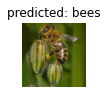

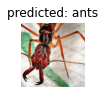

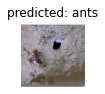

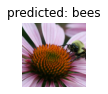

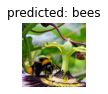

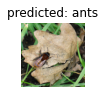

In [24]:
# 可视化一些预测结果
visualize_model(model_conv)

# 实验最后关闭plt的交互模式
plt.ioff()
plt.show()